## 11.1 불안정한 그레디언트 : 그레디언트 소실과 폭주 문제 
- 그레디언트 소실 문제 : 하위층으로 갈수록 그레디언트가 점점 작아지는 경우, 좋은 솔루션으로 수렴이 되지를 않음
- 그레디언트 폭주 문제 : 그레디언트가 점점 커져서 발산하는 경우 - 주로 RNN 

### 11.1.1. 글로럿과 He초기화 
- 신호가 죽거나, 폭주, 또는 소멸하지 않기 위해서는
    - 각 층의 출력에 대한 분산이 입력에 대한 분산이 같아야 한다.
    - 역방향에서 층을 통과하기 전과 후의 그레디언트 분산이 동일해야 한다.
        - fan_in 과 fan_out(입력과 출력 연결 갯수)가 같지 않다면 위의 2가지 보장이 안됨 
        - 이를 보완하기 위하여 각 층의 연결 가중치 무작위 초기화 
- 글로럿 초기화 : 기본적인 케라스의 가중치 초기화 방법        

### 11.1.2. 수렴하지 않는 활성화 함수
- kernel_initializer = he_normal
- kernel_initializer = lecun_normal 

In [54]:
import tensorflow as tf 
from tensorflow import keras 

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

In [55]:
housing = fetch_california_housing() 

In [56]:
housing.data.shape

(20640, 8)

In [57]:
# 테스트, 사용 세트 분리 
X_train_full, X_test, y_train_full, y_test =\
    train_test_split(housing.data, housing.target)

# 학습, 검증 셋 분리 
X_train, X_valid, y_train, y_valid =\
    train_test_split(X_train_full, y_train_full)

In [58]:
X_train.shape

(11610, 8)

In [59]:
y_train.shape

(11610,)

In [63]:
X_test.shape

(5160, 8)

In [64]:
y_test.shape

(5160,)

In [65]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

###### model 생성 
- LeakyRelu
    - LeakyReLU(z)=max(αz, z)로 정의
    - 하이퍼파라미터 α가 이 함수가 ‘새는leaky’ 정도를 결정합니다. 
    - 새는 정도란 z < 0일 때 이 함수의 기울기, 일반적으로 0.01 로 설정
    - ReLU보다 성능이 항상 좋음 

- SELU > ELU > LeakyReLU(그리고 변종들) > ReLU > tanh> 로지스틱 순

In [68]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu',
                      input_shape = X_train.shape[1:]),
    
    # LeakyRelu 
    # 층 생성 후, 적용할 층 뒤에 LeakyReLU 적용  
    keras.layers.Dense(10, kernel_initializer = 'he_normal'),
    keras.layers.LeakyReLU(alpha = 0.3),
    
    # SELU 
    keras.layers.Dense(10, kernel_initializer = 'he_normal'),
    
    # PReLU 
    keras.layers.PReLU(alpha_initializer='zeros'),
    
    # SELU 
    keras.layers.Dense(10, activation = 'selu', 
                      kernel_initializer = 'lecun_normal'),
    
    keras.layers.Dense(1)
])

model.compile(loss = 'mse',
             optimized = 'sgd',
             metrics = ['accuracy'])

model.fit(X_train, y_train,
         validation_data = (X_test, y_test),
         epochs=10)

Train on 11610 samples, validate on 5160 samples
Epoch 1/10
11610/11610 [==============================] - 2s 133us/sample - loss: 0.9523 - accuracy: 0.0033 - val_loss: 0.4610 - val_accuracy: 0.0025
Epoch 2/10
11610/11610 [==============================] - 1s 72us/sample - loss: 0.4267 - accuracy: 0.0033 - val_loss: 0.4204 - val_accuracy: 0.0025
Epoch 3/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.4188 - accuracy: 0.0033 - val_loss: 0.4149 - val_accuracy: 0.0025
Epoch 4/10
11610/11610 [==============================] - 1s 71us/sample - loss: 0.3852 - accuracy: 0.0033 - val_loss: 0.3924 - val_accuracy: 0.0025
Epoch 5/10
11610/11610 [==============================] - 1s 76us/sample - loss: 0.3673 - accuracy: 0.0033 - val_loss: 0.3743 - val_accuracy: 0.0025
Epoch 6/10
11610/11610 [==============================] - 1s 82us/sample - loss: 0.3544 - accuracy: 0.0033 - val_loss: 0.3658 - val_accuracy: 0.0025
Epoch 7/10
11610/11610 [==============================] 

### 11.1.3. 배치 정규화 

- 훈련초기, 그레디언트 소실, 폭주 감소시킬 수 있음
- 훈련 중, 그레디언트 소실, 폭주 방지 
- 각 층에서 활성화 함수를 통과하기 전, 후 모델에 연산 추가 
- 큰 사이즈 훈련시 효과 있음

- γ(출력 스케일 벡터)와 β(출력 이동 벡터)는 일반적인 역전파를 통해 학습
- μ(최종 입력 평균 벡터)와 σ(최종 입력 표준편 차 벡터)는 지수 이동 평균을 사용
    - 각 층마다 4개의 파라미터 γ, β, μ, σ 추가

Training 할 때는 mini-batch의 평균과 분산으로 normalize 하고,  
Test 할 때는 계산해놓은 이동 평균으로 normalize 한다.

- 역전파 학습 :   
    γ(출력 스케일 벡터) / β(출력 이동 벡터) ➤ 역전파 통해 추정 

- 지수 이동 평균을 통해 추정  
    μ(최종 입력 평균 벡터) / σ(최종 입력 표준편 차 벡터) ➤ 지수 이동 평균 사용 추정 

- 중요 파라미터 
    - axis : 학습시키는 데이터의 컬럼 / 피쳐 

In [69]:
import tensorflow as tf 
from tensorflow import keras 

In [70]:
### 데이터 적재 
# fashion dataset : 60000 x 28 x 28 크기 
fashion_mnist = keras.datasets.fashion_mnist 
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [71]:
### 훈련세트와 테스트 세트 분리 
X_valid = X_train_full[:5000] / 255.0

X_train = X_train_full[5000:] / 255.0

y_valid = y_train_full[:5000] / 255.0

y_train = y_train_full[5000:] / 255.0

X_test = X_test / 255.0 

In [72]:
X_train.shape

(55000, 28, 28)

In [73]:
y_train.shape

(55000,)

###### 활성화 함수 이전, 배치 정규과화

In [74]:
# 배치정규화 추가 
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),    
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer = 'he_normal'),
    
    keras.layers.BatchNormalization(), 
    keras.layers.Dense(100, activation='elu', kernel_initializer = 'he_normal'),

    keras.layers.BatchNormalization(), 
    keras.layers.Dense(10, activation = 'softmax')
])

###### 활성화 함수 이후, 배치 정규화 : keras.layers.BatchNormalization() 

In [75]:
X_train.shape

(55000, 28, 28)

In [76]:
y_train.shape

(55000,)

In [77]:
model = keras.models.Sequential([
    
    keras.layers.Flatten(input_shape=[28, 28]), 
    
#     keras.layers.BatchNormalization(),
    
    # 은닉층 : 활성화 함수 지정 안함, use_bias = False
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False), 
    # 배치 정규화 층 입력
    keras.layers.BatchNormalization(),
    # 활성함수 입력 
    keras.layers.Activation("elu"),
    
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False), 
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    
    keras.layers.Dense(10, activation="softmax")
])


In [78]:
model.summary()

# 정규화 층 : 784 * 4개의 파라미터가 추가됨 

'''    
- 아래 그림 
    - 정규화 배치 층 파라미터 : 784 * 4 ( γ, β, μ, σ ) = 3136 
    - gamma : γ / beta : β, 배치 정규화 층에서 mo
'''

 

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 300)               235200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 100)               30000     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)             

'    \n- 아래 그림 \n    - 정규화 배치 층 파라미터 : 784 * 4 ( γ, β, μ, σ ) = 3136 \n    - gamma : γ / beta : β, 배치 정규화 층에서 mo\n'

### 그레이디언트 클리핑 : 배치 정규화가 어려울 때, 그레디언트 < threshold 되도록 clipping 하는 것 

In [79]:
# Clipping 
optimizer = keras.optimizers.SGD(clipvalue=1.0) 

# Clip norm 
# l2 norm이 지정한 임곗값보다 클 경우, 그레디언트 클리핑 
# optimizer = keras.optimizers.SGD(clipnorm=1.0)

model.compile(loss ='sparse_categorical_crossentropy',    
              optimizer=optimizer,
              metrics = ['accuracy']
             )

In [80]:
model.fit(X_train, y_train, 
         epochs = 10)

Train on 55000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 117us/sample - loss: 0.0910 - accuracy: 0.0994
Epoch 2/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.0035 - accuracy: 0.1008
Epoch 3/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.0018 - accuracy: 0.1008
Epoch 4/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.0012 - accuracy: 0.1008
Epoch 5/10
55000/55000 [==============================] - 6s 111us/sample - loss: 9.2878e-04 - accuracy: 0.1008
Epoch 6/10
55000/55000 [==============================] - 6s 108us/sample - loss: 7.3674e-04 - accuracy: 0.1008
Epoch 7/10
55000/55000 [==============================] - 6s 111us/sample - loss: 6.1121e-04 - accuracy: 0.1008
Epoch 8/10
55000/55000 [==============================] - 5s 91us/sample - loss: 5.1736e-04 - accuracy: 0.1008
Epoch 9/10
55000/55000 [==============================] - 5s 94us/sample - loss: 4.5001e-04 - accu

## 11.2 사전훈련된 층 재사용하기 : 전이학습  ( MNIST Fashion 데이터셋 재사용 ) 
- 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음(14장 참조), 그 신경망의 하위층을 재사용하는 방법 
- 보통 원본 모델의 출력층을 바꿔야 합니다. 이 층이 새로운 작업에 가장 유용하지 않는 층이고 새로운 작업에 필요한 출력 개수와 맞지 않을 수도 있습니다.

<img src='./img/11_2_전이학습.jpg'>

1. 새로운 층이 적절한 가중치를 학습할 수 있도록  재사용하는 층을 모두 동결 ( 가중치가 바뀌지 않도록, model.layers[index].trainable = False )     
  
2. 조금의 수를 3,4번의 에포크를 훈련 후 동결을 해제 model.layers[index].trainable = True    
  
3. 모델 재컴파일, 동결 해제 후에는 학습률을 낮춤 -> 재사용된 가중치 손상 방지 ( 학습률 : optimizers.최적화함수(lr = rate ) )

In [81]:
### 데이터 적재 
fashion_mnist = keras.datasets.fashion_mnist 

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# 훈련세트와 테스트 세트 분리 
X_valid = X_train_full[:5000] / 255.0
X_train = X_train_full[5000:] / 255.0
y_valid = y_train_full[:5000] / 255.0
y_train = y_train_full[5000:] / 255.0
X_test = X_test / 255.0 

# 이전 사용하였던 모델을 가져옴 

###### 이전 데이터셋 로드 

In [82]:
model_A = keras.models.load_model("my_model_A.h5")

In [83]:
# model_A의 출력층을 제외한 나머지 층을 가져옴
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])

# model_B_on_A의 출력층 추가
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

- modeal_A와 model_B_on_A는 층을 공유, 모델_B_on_A를 훈련할 때 model_A도 영향을 받음  
- 훈련 시 독립적으로 model_B_on_A를 훈련하고싶다면 clone _model()과 get_weights()를 통해 모델 복사

In [84]:
model_A_clone = keras.models.clone_model(model_A)

# model_A의 가중치를 가져옴 
model_A_clone.set_weights(model_A.get_weights())

###### 기존 가중치 동결, 새로운 층 가중치 학습 

In [85]:
# model_B_on_A 새로운 레이어 : 입력 레이어 ~ 출력 직전 레이어 학습 동결 
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# 출력 직전 레이어 ~ 출력 레이어( 새로운 레이어 ) 가중치 학습 
# 에포크 약간만 주고 학습 
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-2),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train, y_train, epochs=4,
                           validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/4
55000/55000 [==============================] - 4s 76us/sample - loss: 0.0959 - accuracy: 0.1008 - val_loss: 0.0924 - val_accuracy: 0.0914
Epoch 2/4
55000/55000 [==============================] - 4s 65us/sample - loss: 0.0915 - accuracy: 0.1008 - val_loss: 0.0905 - val_accuracy: 0.0914
Epoch 3/4
55000/55000 [==============================] - 4s 71us/sample - loss: 0.0901 - accuracy: 0.1008 - val_loss: 0.0895 - val_accuracy: 0.0914
Epoch 4/4
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0894 - accuracy: 0.1008 - val_loss: 0.0889 - val_accuracy: 0.0914


###### 기존 가중치 동결 해제, 학습

In [86]:
# 재사용된 층의 동결 해제, 모델 다시 학습 - 재사용된 층을 현재 학습을 튜닝하기 위해 훈련 
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# 재사용된 층의 동결을 해제 후, 학습률을 낮추어 재사용된 가중치 유지 
model_B_on_A.compile(loss="mse",
                     optimizer=keras.optimizers.SGD(lr=1e-4),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train, y_train, epochs=16,
                           validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/16
55000/55000 [==============================] - 7s 120us/sample - loss: 2.0876e-04 - accuracy: 0.1008 - val_loss: 1.9012e-04 - val_accuracy: 0.0914
Epoch 2/16
55000/55000 [==============================] - 6s 101us/sample - loss: 2.0592e-04 - accuracy: 0.1008 - val_loss: 1.8784e-04 - val_accuracy: 0.0914
Epoch 3/16
55000/55000 [==============================] - 5s 96us/sample - loss: 2.0340e-04 - accuracy: 0.1008 - val_loss: 1.8582e-04 - val_accuracy: 0.0914
Epoch 4/16
55000/55000 [==============================] - 5s 95us/sample - loss: 2.0115e-04 - accuracy: 0.1008 - val_loss: 1.8404e-04 - val_accuracy: 0.0914
Epoch 5/16
55000/55000 [==============================] - 6s 109us/sample - loss: 1.9915e-04 - accuracy: 0.1008 - val_loss: 1.8245e-04 - val_accuracy: 0.0914
Epoch 6/16
55000/55000 [==============================] - 7s 136us/sample - loss: 1.9734e-04 - accuracy: 0.1008 - val_loss: 1.8102e-04 - val_accuracy: 0.0914
Epoch

In [87]:
model_B_on_A.evaluate(X_test, y_test, verbose = 2)

10000/1 - 1s - loss: 31.1225 - accuracy: 0.1000


[28.332090649414063, 0.1]

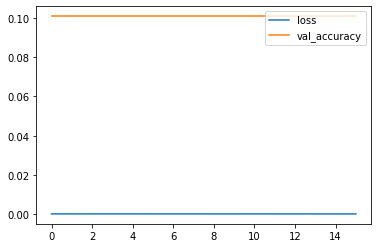

In [88]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['loss', 'val_accuracy'], loc = 'upper right')
plt.show()